<a href="https://colab.research.google.com/github/ThierryJudge/colabs/blob/master/gan_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.python.keras.datasets import mnist
import numpy as np
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
import keras.backend as K
from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import keras
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Convolution2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import backend as K
from keras import initializers

Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

X_train = x_train[..., None] / 255
X_test = x_test[..., None] / 255

y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)


print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 28, 28, 1)
(60000, 10)
(10000, 28, 28, 1)
(10000, 10)


In [0]:
def build_generator():
    input_layer = Input(shape=(28, 28, 1))
    x = input_layer
    x = keras.layers.Conv2D(32, (3, 3), activation=LeakyReLU(0.2), padding='same')(x)
    x = Flatten()(x)
    x = Dense(128, activation=LeakyReLU(0.2), kernel_initializer=initializers.RandomNormal(stddev=0.02))(x)
    #x = Dense(128, activation=LeakyReLU(0.2))(x)

    x = BatchNormalization()(x)

    x = Dense(10, activation='softmax')(x)
    
    model = Model(input_layer, x)
    return model

In [0]:
def build_discriminator():
    input_layer1 = Input(shape=(10,))
    input_layer2 = Input(shape=(10,))
    x = keras.layers.Concatenate(axis=-1)([input_layer1, input_layer2])
    x = Dense(128, activation=LeakyReLU(0.2), kernel_initializer=initializers.RandomNormal(stddev=0.02))(x)
    #x = Dense(128, activation=LeakyReLU(0.2))(x)

    x = BatchNormalization()(x)
    x = Dense(1, activation='sigmoid')(x)
    
    model = Model([input_layer1, input_layer2], x)
    return model

In [0]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [6]:
keras.backend.clear_session()

adam = Adam(lr=0.0002, beta_1=0.5)

# Generator 
generator = build_generator()
generator.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
# generator.summary()

# Discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy', f1])
# discriminator.summary()

# Combined network
discriminator.trainable = False
image_input = Input(shape=(28, 28, 1))
gt_input = Input(shape=(10,))

x = generator(image_input)
ganOutput = discriminator([x, gt_input])
gan = Model(inputs=[image_input, gt_input], outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)
#gan.summary()

/usr/local/lib/python3.6/dist-packages/keras/activations.py:235: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where








Epochs: 0
Generator loss: 2.3359205463409425, accuracy: 0.13023333333333334
Discriminator loss: 0.6847715377807617, accuracy: 0.75, f1: 0.0
Epochs: 1


Generator loss: 10.43459360148112, accuracy: 0.0007166666666666667
Discriminator loss: 0.0030670175328850746, accuracy: 1.0, f1: 0.0
Epochs: 2
Generator loss: 11.49144443613688, accuracy: 0.0005833333333333334
Discriminator loss: 0.0007694364176131785, accuracy: 1.0, f1: 0.0
Epochs: 3
Generator loss: 11.019632411702474, accuracy: 0.00021666666666666666
Discriminator loss: 0.00036238200846128166, accuracy: 1.0, f1: 0.0
Epochs: 4
Generator loss: 11.271329702250164, accuracy: 0.0001
Discriminator loss: 0.0005079074762761593, accuracy: 1.0, f1: 0.0
Epochs: 5
Generator loss: 11.446128263346354, accuracy: 8.333333333333333e-05
Discriminator loss: 5.247458830126561e-05, accuracy: 1.0, f1: 0.0
Epochs: 6
Generator loss: 1.6411690570831299, accuracy: 0.41336666666666666
Discriminator loss: 0.2741473913192749, accuracy: 0.96875, f1: 0.967741

[]

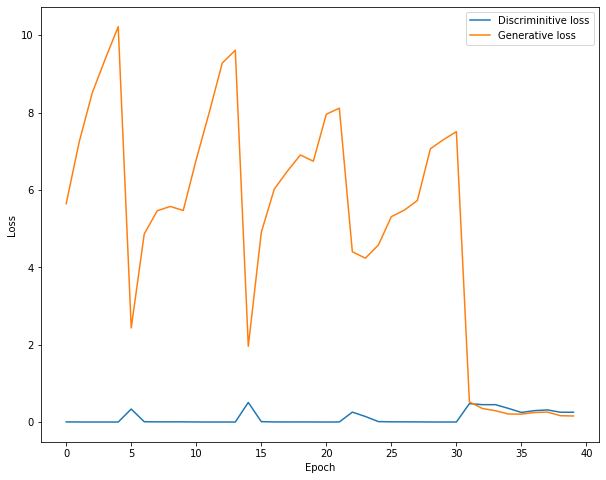

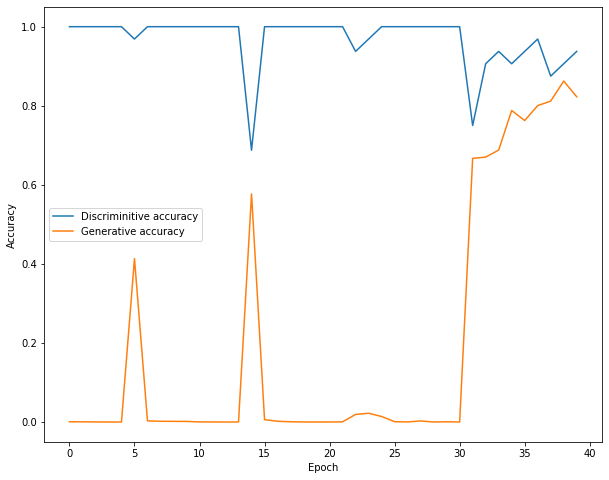

In [7]:
batchSize = 32
epochs = 40
batchCount = X_train.shape[0] / batchSize

dLosses = []
gLosses = []

gacc = []
gl = []
dacc = []
dl = []

# generator.fit(X_train, y_train, epochs=2)
x_batch = X_train[0 * batchSize:(0 + 1) * batchSize]
y_batch = y_train[0 * batchSize:(0 + 1) * batchSize]
y_hat = generator.predict(x_batch)
z = np.equal(np.argmax(y_hat, axis=-1), np.argmax(y_batch, axis=-1)) * 1

print("Epochs: {}".format(0))
gen_eval = generator.evaluate(X_train, y_train, verbose=0)
print("Generator loss: {}, accuracy: {}".format(gen_eval[0], gen_eval[1]))
dis_eval = discriminator.evaluate([y_hat, y_batch], z, verbose=0)
print("Discriminator loss: {}, accuracy: {}, f1: {}".format(dis_eval[0], dis_eval[1], dis_eval[2]))

for e in range(1, epochs+1):
  print("Epochs: {}".format(e))
  for i in (range(int(batchCount))):
    
    x_batch = X_train[i * batchSize:(i + 1) * batchSize]
    y_batch = y_train[i * batchSize:(i + 1) * batchSize]

    #if i < 5:
    
    y_hat = generator.predict(x_batch)

    # Get discriminator labels
    z = (np.equal(np.argmax(y_hat, axis=-1), np.argmax(y_batch, axis=-1)) == 1) * 1

    # Train discriminator
    discriminator.trainable = True
    class_weight = {0: 1.,
                    1: 2.}
    dloss = discriminator.train_on_batch([y_hat, y_batch], z, class_weight=None)


    # Train generator
    yGen = np.ones(batchSize) 
    discriminator.trainable = False
    gloss = gan.train_on_batch([x_batch, y_batch], yGen)

  dLosses.append(dloss[0])
  gLosses.append(gloss)

  gen_eval = generator.evaluate(X_train, y_train, verbose=0)
  print("Generator loss: {}, accuracy: {}".format(gen_eval[0], gen_eval[1]))
  dis_eval = discriminator.evaluate([y_hat, y_batch], z, verbose=0)
  print("Discriminator loss: {}, accuracy: {}, f1: {}".format(dis_eval[0], dis_eval[1], dis_eval[2]))

  gacc.append(gen_eval[1])
  gl.append(gen_eval[0])
  
  dacc.append(dis_eval[1])
  dl.append(dis_eval[0])


plt.figure(figsize=(10, 8))
plt.plot(dLosses, label='Discriminitive loss')
plt.plot(gLosses, label='Generative loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.plot()


plt.figure(figsize=(10, 8))
plt.plot(dacc, label='Discriminitive accuracy')
# plt.plot(gl, label='Discriminitive loss')

plt.plot(gacc, label='Generative accuracy')
# plt.plot(gl, label='Generative loss')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.plot()

In [8]:
  
pred = generator.predict(X_train)
pred = np.argmax(pred, axis=-1)
gt = np.argmax(y_train, axis=-1)

print(np.sum(np.equal(pred, gt))/len(gt))


0.8227333333333333


In [9]:
  gen_eval = generator.evaluate(X_test, y_test, verbose=0)
  print("Generator loss: {}, accuracy: {}".format(gen_eval[0], gen_eval[1]))

Generator loss: 1.8134713214874267, accuracy: 0.8245
